In [2]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits
from astropy.table import Table
from astropy.modeling import models, fitting
from photutils import RectangularAperture, aperture_photometry
import glob, pdb, mpld3
from mpld3 import plugins
from scipy.optimize import curve_fit

plt.rcParams['figure.figsize'] = (12, 6)
mpld3.enable_notebook()

In [3]:
fnames = np.sort(glob.glob('../hst_archive/*_flt.fits'))
len(fnames)

396

In [4]:
img_list = []
hdr_list = []
for fn in fnames:
    hdu = fits.open(fn)
    header = hdu[0].header
    if header['OBSTYPE'] == 'SPECTROSCOPIC':
        image = hdu[1].data
        img_list.append(image)
        hdr_list.append(header)
    hdu.close()
len(img_list)

392

(128, 128)

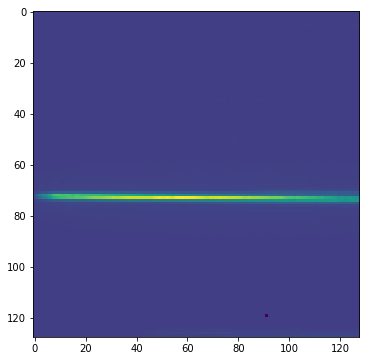

In [12]:
plt.imshow(img_list[20])
img_list[20].shape

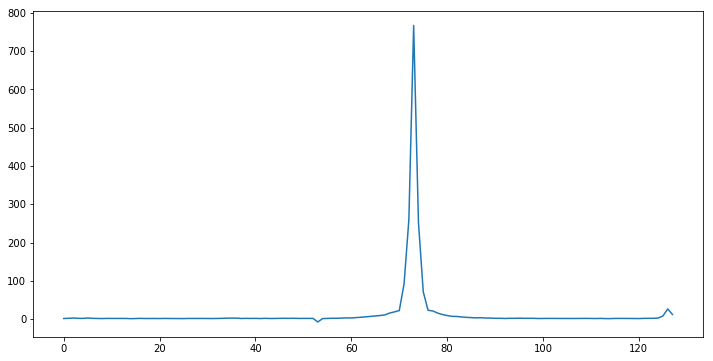

In [20]:
plt.plot(img_list[20][:, 65])

Model: Gaussian1D
Inputs: ('x',)
Outputs: ('y',)
Model set size: 1
Parameters:
      amplitude        mean         stddev    
    ------------- ------------- --------------
    760.727951222 72.9924626255 0.693035307002


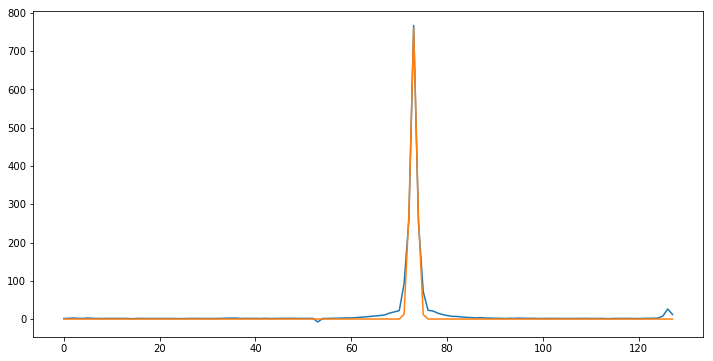

In [23]:
# Fitting gaussian to a column of the spectrum (x=65)

im = img_list[20]
x = range(im.shape[0])
y = im[:, 65]

g_init = models.Gaussian1D(amplitude=760., mean=75., stddev=1.)
fit_g = fitting.LevMarLSQFitter()
g = fit_g(g_init, x, y)
print(g)

plt.plot(x, y)
plt.plot(x, g(x))

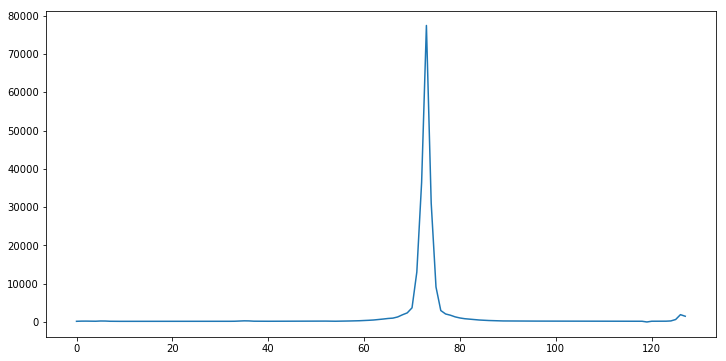

In [29]:
collapsing_spectrum = np.sum(im, axis = 1)

g_init = models.Gaussian1D(amplitude=760., mean=75., stddev=1.)
fit_g = fitting.LevMarLSQFitter()
g = fit_g(g_init, x, y)
print(g)

plt.plot(x, collapsing_spectrum)